In [1]:
import numpy as np
import CRNS_library as CRNS_lib
import time
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import CRNS_optimizer as CRNS_opt
from scipy.optimize import curve_fit
import matplotlib.dates as mdates

# Function to calculate RMSE
def calculate_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())



file_path_15cm = './Alento/Alento2_15cm_precip.txt'
file_path_5cm = './Alento/Alento2_5cm.txt'
alento_site_start=4
alento_site_end=5
#alento_site_start=12
#alento_site_end=13

def func(x, p1, p2):
    return p1 * np.cos(p2 * x) + p2 * np.sin(p1 * x)
print('\nBlock completed at time:                       '+ time.strftime("%H:%M:%S on %Y-%m-%d")) 


Not a file to run, only methods included here.

Block completed at time:                       12:04:46 on 2024-10-04


In [2]:

src_path = '.'
##Read in data for one site as example:
#read incoming neutron intensity
file_path=src_path+'/Scaling/JUNG1_Data_UTC.TXT'
new_data = pd.read_csv(file_path, sep=';', names=['DateTime', 'Incoming'], parse_dates=['DateTime'])
new_data['DateTime'] = pd.to_datetime(new_data['DateTime'])
#print(new_data.head())
Jung = new_data.set_index('DateTime')

##Read in data for one site as example:
#read incoming neutron intensity
file_path=src_path+'/Scaling/OULU_1h_UTC.txt'
new_data = pd.read_csv(file_path, sep=';', names=['DateTime', 'Oulu'], parse_dates=['DateTime'])
new_data['DateTime'] = pd.to_datetime(new_data['DateTime'])
#print(new_data.head())
Oulu = new_data.set_index('DateTime')


##Read in data for one site as example:
#read incoming neutron intensity
file_path=src_path+'/Scaling/LMKS.txt'
new_data = pd.read_csv(file_path, sep=';', names=['DateTime', 'Lmks'], parse_dates=['DateTime'])
new_data['DateTime'] = pd.to_datetime(new_data['DateTime'])
#print(new_data.head())
Lmks = new_data.set_index('DateTime')

##Read in data for one site as example:
#read incoming neutron intensity
file_path=src_path+'/Scaling/APTY_1h_UTC.txt'
new_data = pd.read_csv(file_path, sep=';', names=['DateTime', 'Apty'], parse_dates=['DateTime'])
new_data['DateTime'] = pd.to_datetime(new_data['DateTime'])
#print(new_data.head())
Apty = new_data.set_index('DateTime')



##Read in data for one site as example:
#read incoming neutron ray intensity
file_path=src_path+'/Scaling/AthensR8.53Alt260 m.txt'
new_data = pd.read_csv(file_path, sep=';', names=['DateTime', 'Athens'], parse_dates=['DateTime'])
new_data['DateTime'] = pd.to_datetime(new_data['DateTime'])
#print(new_data.head())
Athens = new_data.set_index('DateTime')


##Read in data for one site as example:
#read incoming neutron ray intensity
file_path=src_path+'/Scaling/MXCO_1h_UTC8.28Alt2274m.txt'
new_data = pd.read_csv(file_path, sep=';', names=['DateTime', 'Mxco'], parse_dates=['DateTime'])
new_data['DateTime'] = pd.to_datetime(new_data['DateTime'])
#print(new_data.head())
Mxco = new_data.set_index('DateTime')

print('\nBlock completed at time:                       '+ time.strftime("%H:%M:%S on %Y-%m-%d")) 


Block completed at time:                       12:04:47 on 2024-10-04


In [3]:

## Schäfertal ID 3 removed; and columns renamed; asterisk remarks removed; BUC001 data gaps were removed
fname='EU_Study_sites.csv'
fname="./Scaling/COSMOS_Europe_Data/Additional_information.csv"
site_info = pd.read_csv(fname)
fname="./Scaling/COSMOS_Europe_Data/General_information.csv"
site_general_info = pd.read_csv(fname)
sites_names = site_info.StationID.to_list()
CutoffRigidity = site_info.CutoffRigidity.to_list()
sites_Bulkdensity = site_info.Bulkdensity.to_list()
sites_Altitude = site_general_info.Altitude.to_list()
sites_Precip = site_general_info.Meanannualprecipitation.to_list()
sites_Temperature = site_general_info.Meanairtemperature.to_list()
sites_lat = site_general_info.Latitude.to_list()
dfi = pd.DataFrame({
    'StationID': sites_names,
    'CutoffRigidity': CutoffRigidity,
    'sites_Precip': sites_Precip,
    'sites_Temperature': sites_Temperature,
    'Bulkdensity': sites_Bulkdensity,
    'Altitude': sites_Altitude
})

# Add new columns (beta, omega, psi) with initial values (you can update these later)
dfi['beta'] = np.nan
dfi['beta_sd'] = np.nan
dfi['beta_mae'] = np.nan
dfi['beta_rmse'] = np.nan
dfi['beta_oulu'] = np.nan
dfi['beta_apty'] = np.nan
dfi['beta_lmks'] = np.nan
dfi['beta_mxco'] = np.nan
dfi['beta_athens'] = np.nan
dfi['omega'] = np.nan
dfi['omega_sd'] = np.nan
dfi['omega_oulu'] = np.nan
dfi['omega_apty'] = np.nan
dfi['omega_mxco'] = np.nan
dfi['omega_athens'] = np.nan
dfi['omega_lmks'] = np.nan
dfi['omega_mae'] = np.nan
dfi['omega_rmse'] = np.nan
dfi['psi'] = np.nan
dfi['psi_sd'] = np.nan
dfi['psi_oulu'] = np.nan
dfi['psi_apty'] = np.nan
dfi['psi_athens'] = np.nan
dfi['psi_mxco'] = np.nan
dfi['psi_lmks'] = np.nan
dfi['psi_mae'] = np.nan
dfi['psi_rmse'] = np.nan
dfi['BetaDesilets'] = np.nan
dfi['mean_P'] = np.nan

print('\nBlock completed at time:                       '+ time.strftime("%H:%M:%S on %Y-%m-%d")) 



Block completed at time:                       12:04:47 on 2024-10-04


In [4]:
import os
### Iterate over EU Study sites
#Read CRNS and calibrate
plog_flag_id=0
suffix_csv = "rmse_u"
csv_filename=f'my_dataframe_moderated_{suffix_csv}.csv'

if os.path.exists(csv_filename):
    dfi = pd.read_csv(csv_filename, sep=';', index_col=0)  # Set index_col to 0 for row names
    #LOAD DATAFRAME FROM CSV
else:
    print("ERROR File not present")
    exithere()
    
    

In [5]:


beta = dfi.loc[alento_site_start, 'beta']
omega = dfi.loc[alento_site_start, 'omega']
psi = dfi.loc[alento_site_start, 'psi']
SiteName_Alento = dfi.loc[alento_site_start,'StationID']
print("Beta=", beta)
print("omega=",omega)
print("psi=",psi)
print("Name=",SiteName_Alento)

Beta= -0.0061914127094869
omega= -0.0064169234261513
psi= 0.3208475908730378
Name= ALC002


In [6]:

for ii, nn in enumerate(sites_names[alento_site_start:alento_site_end], start=alento_site_start):
    print("ID:",ii, "Reading:",nn)
    #if nn in ['BUC001']:
    #    pass
    #else:
    #print(ii, nn,sites[ii]) #ID, site and fname, same
    DF = CRNS_lib.load_EU_data(src_path+'/Scaling/COSMOS_Europe_Data/',nn)
    DF['Abs_h'] = CRNS_opt.Absolute_conv(DF.RH, DF.TEMP)
    #resample to 1 hour exactly, for merging with 1h inc. radiation
    DF = DF.resample('1H').mean()

    #print(DF.tail(3))
    DF = DF.join(Jung)
    DF = DF.join(Apty)
    DF = DF.join(Oulu)
    DF = DF.join(Athens)
    DF = DF.join(Mxco)
    DF = DF.join(Lmks)
    #print(DF.head(3))
    #print("")
    #print(DF.tail(3))
    #calculate relative scaling for inc. radiation
    
    # Normalizing and masking outliers for each column
    prctl_values = [0.1, 0.1, 0.1, 0.4, 0.1, 0.1]
    columns = ["Incoming", "Apty", "Oulu", "Mxco", "Lmks", "Athens"]
    for idcol, col in enumerate(columns):
        lower = 0+prctl_values[idcol]
        upper=100-prctl_values[idcol]
        lower, upper = np.percentile(DF[col].dropna(), [lower,upper])
        DF[col] = DF[col].mask((DF[col] < lower) | (DF[col] > upper))
    
    DF["Incoming"] = DF["Incoming"]/np.nanmean(DF["Incoming"])
    DF["Apty"] = DF["Apty"]/np.nanmean(DF["Apty"])
    DF["Oulu"] = DF["Oulu"]/np.nanmean(DF["Oulu"])
    DF["Mxco"] = DF["Mxco"]/np.nanmean(DF["Mxco"])
    DF["Lmks"] = DF["Lmks"]/np.nanmean(DF["Lmks"])
    DF["Athens"] = DF["Athens"]/np.nanmean(DF["Athens"])
    
    mydf = pd.concat([DF['Pressure'],DF["MOD"],DF["Incoming"],DF["Abs_h"]], axis=1)
    mydf.columns = ['Pressure', 'MOD', 'Incoming', 'Abs_h']

    """
    #check for ranges and remove outliers
    """

    print("Len before removing values out of range:", len(mydf))
    #print(mydf.tail(48))
    mydf.loc[mydf['MOD'] < 50, 'MOD'] = np.nan
    mydf.loc[mydf['MOD'] > 6000, 'MOD'] = np.nan
    mydf.loc[mydf['Pressure'] < 400, 'Pressure'] = np.nan
    mydf.loc[mydf['Pressure'] > 1200, 'Pressure'] = np.nan
    mydf.loc[mydf['Incoming'] < 0.5, 'Incoming'] = np.nan
    mydf.loc[mydf['Incoming'] > 1.5, 'Incoming'] = np.nan
    mydf.loc[mydf['Abs_h'] < 0, 'Abs_h'] = np.nan
    mydf.loc[mydf['Abs_h'] > 35, 'Abs_h'] = np.nan
    
    mydf=mydf.dropna(subset=['MOD'])
    mydf=mydf.dropna(subset=['Pressure'])
    mydf=mydf.dropna(subset=['Incoming'])
    mydf=mydf.dropna(subset=['Abs_h'])

    #print(mydf.tail(48))
    print("Len after removing values out of range:", len(mydf))

    """
    #check for nearest neighboor and remove those with neutron count difference larger 10% to nn+/-1
    """
    mydf['MOD_diff_minus_1'] = abs(mydf.MOD.pct_change(periods=-1)) # difference in neutron count
    mydf['MOD_diff_plus_1'] = abs(mydf.MOD.pct_change(periods=1)) # difference in neutron count
    mydf = mydf[(mydf['MOD_diff_minus_1']  <= 0.10)&(mydf['MOD_diff_plus_1']  <= 0.10)]


    mydf['MOD_diff_minus_1'] = abs(mydf.Pressure.pct_change(periods=-1)) # difference in air pressure
    mydf['MOD_diff_plus_1'] = abs(mydf.Pressure.pct_change(periods=1)) # difference in air pressure
    mydf = mydf[(mydf['MOD_diff_minus_1']  <= 0.10)&(mydf['MOD_diff_plus_1']  <= 0.10)]
    print("Len after removing values MOD_diff_plus_1 and MOD_diff_minus_1:", len(mydf))

    mydf['MOD_diff_minus_1'] = abs(mydf.Abs_h.pct_change(periods=-1)) # difference in air h
    mydf['MOD_diff_plus_1'] = abs(mydf.Abs_h.pct_change(periods=1)) # difference in air h
    mydf = mydf[(mydf['MOD_diff_minus_1']  <= 0.10)&(mydf['MOD_diff_plus_1']  <= 0.10)]
    
    print("Len after removing values MOD_diff_plus_1 and MOD_diff_minus_1:", len(mydf))
    #print(mydf.tail(10))
    #print(mydf.head(3))
    
    daily_df = mydf.resample('D').mean()
    print("daily_df Min Max and SD and NA.ct are       :", np.nanmin(daily_df), np.nanmax(daily_df), np.nanstd(daily_df),np.count_nonzero(np.isnan(daily_df)))
    
    daily_df=daily_df.dropna(subset=['MOD'])
    daily_df=daily_df.dropna(subset=['Pressure'])
    daily_df=daily_df.dropna(subset=['Incoming'])
    daily_df=daily_df.dropna(subset=['Abs_h'])
    
    #print(daily_df.tail(10))
    print("daily_df Min Max and SD and NA.ct NA.drop   :", np.nanmin(daily_df), np.nanmax(daily_df), np.nanstd(daily_df),np.count_nonzero(np.isnan(daily_df)))
    # Step 2: Calculate daily differences
    # Prepare data for optimization
    mod_values = daily_df['MOD'].values
    pressure_values = daily_df['Pressure'].values
    incoming_values = daily_df['Incoming'].values
    abs_h_values = daily_df['Abs_h'].values
print("\n daily_df head:")
print(daily_df.head(3))
print('\nBlock completed at time:                       '+ time.strftime("%H:%M:%S on %Y-%m-%d")) 


ID: 4 Reading: ALC002
Len before removing values out of range: 48163
Len after removing values out of range: 45108
Len after removing values MOD_diff_plus_1 and MOD_diff_minus_1: 44690
Len after removing values MOD_diff_plus_1 and MOD_diff_minus_1: 38100
daily_df Min Max and SD and NA.ct are       : 0.007291057613145029 2034.8333333333333 675.9620098933322 708
daily_df Min Max and SD and NA.ct NA.drop   : 0.007291057613145029 2034.8333333333333 675.9620098933322 0

 daily_df head:
              Pressure          MOD  Incoming     Abs_h  MOD_diff_minus_1  \
Date                                                                        
2016-02-08  967.990000  1585.200000  0.972798  8.837205          0.024874   
2016-02-09  965.591667  1625.666667  0.971088  8.336541          0.030163   
2016-02-10  953.840909  1764.954545  0.974930  7.869037          0.035525   

            MOD_diff_plus_1  
Date                         
2016-02-08         0.025175  
2016-02-09         0.029981  
2016-02-

In [7]:
# Step 1: Read the CSV file
data = pd.read_csv(file_path_15cm, delim_whitespace=True)
# Step 2: Group by Year, Month, and Day
grouped = data.groupby(['Year', 'Month', 'Day'])
# Step 3: Filter out days with 2 or more missing entries
valid_days = grouped.filter(lambda x: x.shape[0] >= 22)
# Step 4: Compute daily averages
daily_avg_swc = valid_days.groupby(['Year', 'Month', 'Day']).mean().reset_index()

# Step 1: Read the CSV file
data = pd.read_csv(file_path_5cm, delim_whitespace=True)
# Step 2: Group by Year, Month, and Day
grouped = data.groupby(['Year', 'Month', 'Day'])
# Step 3: Filter out days with 2 or more missing entries
valid_days = grouped.filter(lambda x: x.shape[0] >= 22)
# Step 4: Compute daily averages
daily_avg_swc_5cm = valid_days.groupby(['Year', 'Month', 'Day']).mean().reset_index()

###Merge two dataframes for where data is present
df_daily_avg_swc = pd.DataFrame(daily_avg_swc)
df_daily_avg_swc['Date'] = pd.to_datetime(df_daily_avg_swc[['Year', 'Month', 'Day']])
df_daily_avg_swc.drop(['Year', 'Month', 'Day','Hour'], axis=1, inplace=True)

df_daily_avg_swc_5cm = pd.DataFrame(daily_avg_swc_5cm)
df_daily_avg_swc_5cm['Date'] = pd.to_datetime(df_daily_avg_swc_5cm[['Year', 'Month', 'Day']])
df_daily_avg_swc_5cm.drop(['Year', 'Month', 'Day','Hour'], axis=1, inplace=True)

# Merging the DataFrames
merged_df = pd.merge(daily_df, df_daily_avg_swc, on='Date', how='inner')
merged_df = pd.merge(merged_df, df_daily_avg_swc_5cm, on='Date', how='inner')
print(" HEAD ")
print(merged_df.head(3))
print('\nBlock completed at time:                       '+ time.strftime("%H:%M:%S on %Y-%m-%d")) 


 HEAD 
        Date    Pressure          MOD  Incoming     Abs_h  MOD_diff_minus_1  \
0 2019-11-09  956.029167  1712.166667  1.005313  9.569509          0.026419   
1 2019-11-10  957.218182  1731.500000  1.005015  8.715824          0.031916   
2 2019-11-11  955.714286  1738.142857  1.005433  8.615023          0.035684   

   MOD_diff_plus_1  SWC_15cm  Abs_Humidity  Rainfall      air_T   SWC_5cm  
0         0.025559  0.485204      0.026890  1.076708   8.136167  0.296809  
1         0.027889  0.468033      0.047880  0.450042   7.266375  0.290641  
2         0.039187  0.412525      0.014426  0.008333  14.760000  0.270782  

Block completed at time:                       12:04:50 on 2024-10-04


In [8]:
### for the merged_df: Identify a 5 day period with 5 days of measurement, where Incoming changes strongly, and Rainfall is 0.
#save this period as index.
# Plot MOD, Incoming, Abs_h, and average_SM for this period only.

myvars = ['Incoming','Abs_h','Pressure']
for iiid, myvar in enumerate(myvars):
    print(myvar, iiid)
    if myvar=='Abs_h':
        my_vars_diff = "Abs_diff"
    else:
        my_vars_diff = f'{myvar}_diff'
    print(my_vars_diff)
    merged_df[my_vars_diff] = merged_df[myvar].diff().abs()
    """
    filtered_df = merged_df.copy()
    temp_df = filtered_df[my_vars_diff].fillna(-np.inf)
    
    # Find the top 3 maximum values and their indices
    top_3_values = temp_df.nlargest(3).values
    top_3_indices = temp_df.nlargest(3).index
    
    print(f"Top 3 change values: {top_3_values}")
    print(f"Indices of top 3 changes: {top_3_indices}")

    for i, (max_value, max_index) in enumerate(zip(top_3_values, top_3_indices), 1):
        print(f"\nMax change value {i}: {max_value}")
        print(f"Index of max change {i}: {max_index}")

        index = filtered_df.index[filtered_df[my_vars_diff] == max_value].tolist()
        if index:
            extracted_index = index[0]  # Assuming you want the first match if duplicates
        else:
            extracted_index = None  # Handle the case where no match is found

        print(f"Extracted Index {i}: {extracted_index}")
        print(f"Extracted Index {i}: {extracted_index}, {filtered_df.loc[extracted_index, my_vars_diff]}")
        print(" ")

        # Display surrounding rows for the extracted index
        print(merged_df.loc[(extracted_index-2):(extracted_index+2), ['Date', myvar, my_vars_diff, 'Rainfall', 'SWC_15cm', 'SWC_5cm']])
        print(" ")
    """
print('\nBlock completed at time:                       '+ time.strftime("%H:%M:%S on %Y-%m-%d")) 


Incoming 0
Incoming_diff
Abs_h 1
Abs_diff
Pressure 2
Pressure_diff

Block completed at time:                       12:04:50 on 2024-10-04


In [9]:
filtered_df = merged_df.copy()
printflag=0

# Filter for periods where over THREE days: Rainfall == 0
inc_df = filtered_df['Incoming_diff'].fillna(-np.inf)
absh_df = filtered_df['Abs_diff'].fillna(-np.inf)
pressure_df = filtered_df['Pressure_diff'].fillna(-np.inf)

# Find the maximum value and its index
for ii in range(1,10):
    # Get the second largest value in column 'A'
    my_n_largest = filtered_df['Incoming_diff'].nlargest(ii).iloc[-1]
    my_index=filtered_df['Incoming_diff']==my_n_largest
    max_index = inc_df.idxmax()
    
    index = filtered_df.index[filtered_df['Incoming_diff'] == my_n_largest].tolist()
    if index:
        extracted_index = index[0]  # Assuming you want the first match
    else:
        extracted_index = None  # Handle the case where no match is found
    tmp_val=filtered_df.loc[extracted_index, 'Incoming_diff']*100
    if printflag:
        print("Extracted Index:", extracted_index, f'Value = {tmp_val:.1f} %')
        print(" ")
        print(merged_df.loc[(extracted_index-2):(extracted_index+2),['Date','Incoming','Incoming_diff','Rainfall','SWC_5cm']])
        #print(merged_df.loc[(extracted_index-2):(extracted_index+2),['Date','Incoming','Incoming_diff','Rainfall','SWC_15cm','SWC_5cm']])
        print(" ")

    
    # Get the second largest value in column 'A'
    my_n_largest = filtered_df['Pressure_diff'].nlargest(ii).iloc[-1]
    #my_n_largest = filtered_df['Incoming_diff'].nsmallest(ii).iloc[-1]
    my_index=filtered_df['Pressure_diff']==my_n_largest
    max_index = pressure_df.idxmax()

    if printflag: print(" ")
    index = filtered_df.index[filtered_df['Pressure_diff'] == my_n_largest].tolist()
    if index:
        extracted_index = index[0]  # Assuming you want the first match
    else:
        extracted_index = None  # Handle the case where no match is found
    tmp_val=filtered_df.loc[extracted_index, 'Pressure_diff']
    if printflag:
        print("Extracted Index:", extracted_index, f'Value = {tmp_val:.1f} hPa')
        print(" ")
        print(merged_df.loc[(extracted_index-2):(extracted_index+2),['Date','Pressure','Pressure_diff','Rainfall','SWC_5cm']])
        print(" ")

    
    # Get the second largest value in column 'A'
    my_n_largest = filtered_df['Abs_diff'].nlargest(ii).iloc[-1]
    #my_n_largest = filtered_df['Incoming_diff'].nsmallest(ii).iloc[-1]
    my_index=filtered_df['Abs_diff']==my_n_largest
    max_index = absh_df.idxmax()

    if printflag: print(" ")
    index = filtered_df.index[filtered_df['Abs_diff'] == my_n_largest].tolist()
    if index:
        extracted_index = index[0]  # Assuming you want the first match
    else:
        extracted_index = None  # Handle the case where no match is found
    tmp_val=filtered_df.loc[extracted_index, 'Abs_diff']
    if printflag:
        print("Extracted Index:", extracted_index, f'Value = {tmp_val:.1f} Abs. Humidity')
        print(" ")
        print(merged_df.loc[(extracted_index-2):(extracted_index+2),['Date','Abs_h','Abs_diff','Rainfall','SWC_5cm']])
        #print(merged_df.loc[(extracted_index-2):(extracted_index+2),['Date','Incoming','Incoming_diff','Rainfall','SWC_15cm','SWC_5cm']])
        print(" ")
print('\nBlock completed at time:                       '+ time.strftime("%H:%M:%S on %Y-%m-%d")) 



Block completed at time:                       12:04:50 on 2024-10-04


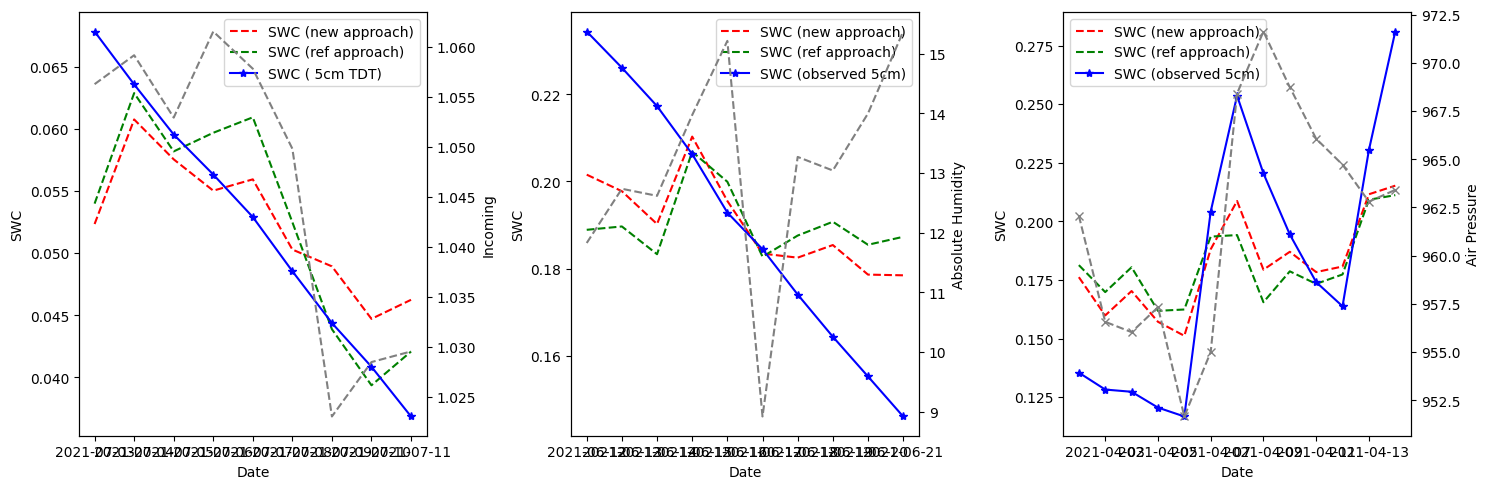

Save file as ./plots/Alento2.png

Block completed at time:                       12:04:51 on 2024-10-04


In [10]:
filtered_df = merged_df.copy()

#extended range
inc_indices=np.arange(523,532,1)
abs_indices=np.arange(502,512,1)
pres_indices=np.arange(432,445,1)





filtered_df = merged_df.copy()

beta_ref=-0.0076
omega_ref=-0.0054
psi_ref=0.8
bd = 1.126
lw=0.055

p_ref=np.nanmean(filtered_df['Pressure'])
i_ref=np.nanmean(filtered_df['Incoming'])
h_ref=np.nanmean(filtered_df['Abs_h'])

beta = dfi.loc[alento_site_start, 'beta']
omega = dfi.loc[alento_site_start, 'omega']
psi = dfi.loc[alento_site_start, 'psi']

SWC_calib = filtered_df.loc[inc_indices[0],['SWC_5cm']].values

cor_p_new = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta)
cor_h_new = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega)
cor_i_new = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi)

filtered_df["MOD_new"] = filtered_df['MOD'] / cor_p_new / cor_i_new / cor_h_new
Npih_calibrated = filtered_df.loc[inc_indices[0],"MOD_new"]
N0_new = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_new = ((0.0808/((filtered_df.loc[inc_indices,"MOD_new"]/N0_new)-0.372)-0.115)*bd)-lw



cor_p = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta_ref)
cor_h = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega_ref)
cor_i = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi_ref)

filtered_df["MOD_standard"] = filtered_df['MOD'] / cor_p / cor_i / cor_h
Npih_calibrated = filtered_df.loc[inc_indices[0],"MOD_standard"]
N0_standard = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_standard = ((0.0808/((filtered_df.loc[inc_indices,"MOD_standard"]/N0_standard)-0.372)-0.115)*bd)-lw




SWC_calib = np.mean(filtered_df.loc[inc_indices,['SWC_5cm']].values)

cor_p_new = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta)
cor_h_new = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega)
cor_i_new = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi)

filtered_df["MOD_new"] = filtered_df['MOD'] / cor_p_new / cor_i_new / cor_h_new
Npih_calibrated = np.mean(filtered_df.loc[inc_indices,"MOD_new"])
N0_new = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_new = ((0.0808/((filtered_df.loc[inc_indices,"MOD_new"]/N0_new)-0.372)-0.115)*bd)-lw



cor_p = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta_ref)
cor_h = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega_ref)
cor_i = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi_ref)

filtered_df["MOD_standard"] = filtered_df['MOD'] / cor_p / cor_i / cor_h
Npih_calibrated = np.mean(filtered_df.loc[inc_indices,"MOD_standard"])
N0_standard = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_standard = ((0.0808/((filtered_df.loc[inc_indices,"MOD_standard"]/N0_standard)-0.372)-0.115)*bd)-lw



# Create a figure with three columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax1 = axes[0]
# Plot the four SWC lines
ax1.plot(filtered_df.loc[inc_indices,'Date'], SWC_new,       label='SWC (new approach)', color='red', linestyle='--')
ax1.plot(filtered_df.loc[inc_indices,'Date'], SWC_standard,  label='SWC (ref approach)', color='green', linestyle='--')
ax1.plot(filtered_df.loc[inc_indices,'Date'], filtered_df.loc[inc_indices, 'SWC_5cm'],  label='SWC ( 5cm TDT)', color='blue', marker='*',linestyle='-')
#ax1.plot(filtered_df.loc[inc_indices,'Date'], filtered_df.loc[inc_indices, 'SWC_5cm'], label='SWC (observed 5cm)', color='blue', marker='',linestyle='-')
#ax1.plot(filtered_df.loc[inc_indices,'Date'], filtered_df.loc[inc_indices, 'SWC_15cm'], label='SWC (15cm TDT)', color='purple', linestyle=':')
# Add a legend
ax1.legend()
# Add labels
ax1.set_xlabel('Date')
ax1.set_ylabel('SWC')
# Create a second y-axis for 'Incoming'
ax2 = ax1.twinx()
ax2.plot(filtered_df.loc[inc_indices,'Date'], filtered_df.loc[inc_indices, 'Incoming'], label='Incoming', color='grey', linestyle='--')
ax2.set_ylabel('Incoming')
# Add a legend for the secondary y-axis


the_indices = abs_indices
SWC_calib = filtered_df.loc[the_indices[0],['SWC_5cm']].values

cor_p_new = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta)
cor_h_new = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega)
cor_i_new = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi)

filtered_df["MOD_new"] = filtered_df['MOD'] / cor_p_new / cor_i_new / cor_h_new
Npih_calibrated = filtered_df.loc[the_indices[0],"MOD_new"]
N0_new = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_new = ((0.0808/((filtered_df.loc[the_indices,"MOD_new"]/N0_new)-0.372)-0.115)*bd)-lw



cor_p = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta_ref)
cor_h = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega_ref)
cor_i = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi_ref)

filtered_df["MOD_standard"] = filtered_df['MOD'] / cor_p / cor_i / cor_h
Npih_calibrated = filtered_df.loc[the_indices[0],"MOD_standard"]
N0_standard = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_standard = ((0.0808/((filtered_df.loc[the_indices,"MOD_standard"]/N0_standard)-0.372)-0.115)*bd)-lw




SWC_calib = np.mean(filtered_df.loc[the_indices,['SWC_5cm']].values)

cor_p_new = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta)
cor_h_new = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega)
cor_i_new = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi)

filtered_df["MOD_new"] = filtered_df['MOD'] / cor_p_new / cor_i_new / cor_h_new
Npih_calibrated = np.mean(filtered_df.loc[the_indices,"MOD_new"])
N0_new = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_new = ((0.0808/((filtered_df.loc[the_indices,"MOD_new"]/N0_new)-0.372)-0.115)*bd)-lw



cor_p = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta_ref)
cor_h = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega_ref)
cor_i = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi_ref)

filtered_df["MOD_standard"] = filtered_df['MOD'] / cor_p / cor_i / cor_h
Npih_calibrated = np.mean(filtered_df.loc[the_indices,"MOD_standard"])
N0_standard = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_standard = ((0.0808/((filtered_df.loc[the_indices,"MOD_standard"]/N0_standard)-0.372)-0.115)*bd)-lw



ax1 = axes[1]
# Plot the four SWC lines
ax1.plot(filtered_df.loc[the_indices,'Date'], SWC_new,       label='SWC (new approach)', color='red', linestyle='--')
ax1.plot(filtered_df.loc[the_indices,'Date'], SWC_standard,  label='SWC (ref approach)', color='green', linestyle='--')
ax1.plot(filtered_df.loc[the_indices,'Date'], filtered_df.loc[the_indices, 'SWC_5cm'], label='SWC (observed 5cm)', color='blue', marker='*',linestyle='-')
#ax1.plot(filtered_df.loc[the_indices,'Date'], filtered_df.loc[the_indices, 'SWC_15cm'], label='SWC (15cm TDT)', color='purple', linestyle=':')
ax1.legend()
# Add labels
ax1.set_xlabel('Date')
ax1.set_ylabel('SWC')
# Create a second y-axis for 'Incoming'
ax2 = ax1.twinx()
ax2.plot(filtered_df.loc[the_indices,'Date'], filtered_df.loc[the_indices, 'Abs_h'], color='grey', linestyle='--')
ax2.set_ylabel('Absolute Humidity')
# Add a legend for the secondary y-axis




the_indices = pres_indices
SWC_calib = filtered_df.loc[the_indices[0],['SWC_5cm']].values

cor_p_new = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta)
cor_h_new = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega)
cor_i_new = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi)

filtered_df["MOD_new"] = filtered_df['MOD'] / cor_p_new / cor_i_new / cor_h_new
Npih_calibrated = filtered_df.loc[the_indices[0],"MOD_new"]
N0_new = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_new = ((0.0808/((filtered_df.loc[the_indices,"MOD_new"]/N0_new)-0.372)-0.115)*bd)-lw



cor_p = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta_ref)
cor_h = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega_ref)
cor_i = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi_ref)

filtered_df["MOD_standard"] = filtered_df['MOD'] / cor_p / cor_i / cor_h
Npih_calibrated = filtered_df.loc[the_indices[0],"MOD_standard"]
N0_standard = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_standard = ((0.0808/((filtered_df.loc[the_indices,"MOD_standard"]/N0_standard)-0.372)-0.115)*bd)-lw




SWC_calib = np.mean(filtered_df.loc[the_indices,['SWC_5cm']].values)

cor_p_new = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta)
cor_h_new = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega)
cor_i_new = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi)

filtered_df["MOD_new"] = filtered_df['MOD'] / cor_p_new / cor_i_new / cor_h_new
Npih_calibrated = np.mean(filtered_df.loc[the_indices,"MOD_new"])
N0_new = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_new = ((0.0808/((filtered_df.loc[the_indices,"MOD_new"]/N0_new)-0.372)-0.115)*bd)-lw



cor_p = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta_ref)
cor_h = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega_ref)
cor_i = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi_ref)

filtered_df["MOD_standard"] = filtered_df['MOD'] / cor_p / cor_i / cor_h
Npih_calibrated = np.mean(filtered_df.loc[the_indices,"MOD_standard"])
N0_standard = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_standard = ((0.0808/((filtered_df.loc[the_indices,"MOD_standard"]/N0_standard)-0.372)-0.115)*bd)-lw



ax1 = axes[2]
# Plot the four SWC lines
ax1.plot(filtered_df.loc[the_indices,'Date'], SWC_new,       label='SWC (new approach)', color='red', linestyle='--')
ax1.plot(filtered_df.loc[the_indices,'Date'], SWC_standard,  label='SWC (ref approach)', color='green', linestyle='--')
ax1.plot(filtered_df.loc[the_indices,'Date'], filtered_df.loc[the_indices, 'SWC_5cm'], label='SWC (observed 5cm)', color='blue', marker='*',linestyle='-')
#ax1.plot(filtered_df.loc[the_indices,'Date'], filtered_df.loc[the_indices, 'SWC_15cm'], label='SWC (15cm TDT)', color='purple', linestyle=':')
ax1.legend()
# Add labels
ax1.set_xlabel('Date')
ax1.set_ylabel('SWC')
# Create a second y-axis for 'Incoming'
ax2 = ax1.twinx()
ax2.plot(filtered_df.loc[the_indices,'Date'], filtered_df.loc[the_indices, 'Pressure'], color='grey', linestyle='--',marker='x')
ax2.set_ylabel('Air Pressure')
# Add a legend for the secondary y-axis

# Adjust layout to prevent overlap
fig.tight_layout()

# Show plot
plt.show()


pngname="./plots/Alento2.png"
print("Save file as "+pngname)
fig.savefig(pngname, bbox_inches='tight')

print('\nBlock completed at time:                       '+ time.strftime("%H:%M:%S on %Y-%m-%d")) 


In [11]:

import matplotlib.dates as mdates
filtered_df = merged_df.copy()


# Convert 'Date' column to datetime format if not already
#filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])

# Set 'Date' column as the index
#filtered_df.set_index('Date', inplace=True)


#print(filtered_df.index)
# Ensure the index is in datetime format
#filtered_df.index = pd.to_datetime(filtered_df.index)#

#print(filtered_df.index)

beta_ref=-0.0076
omega_ref=-0.0054
psi_ref=0.8
bd = 1.126
lw=0.055

filtered_df["SWC_Weighted"] = filtered_df["SWC_15cm"].copy()
depths = [0.05, 0.15]  # depths in cm
depths = [0.15, 0.30]  # depths in cm
radial_distance = 0  # assuming no radial distribution
print("LENGTH:")
print(len(filtered_df))
##Calculate weighting:
for ii in range(len(filtered_df)):
    #print(ii)
    swc_values = [filtered_df.loc[ii,"SWC_5cm"]+lw, filtered_df.loc[ii,"SWC_15cm"]+lw]
    # Calculate weighted SWC
    weighted_swcs = []
    for d, swc in zip(depths, swc_values):
        weight = CRNS_lib.Wd(d, radial_distance, bd, swc)
        weighted_swcs.append(swc * weight)

    # Calculate average weighted SWC
    average_weighted_swc = sum(weighted_swcs) / len(weighted_swcs)
    #print(f"Average Weighted SWC: {average_weighted_swc}")
    filtered_df.loc[ii,"SWC_Weighted"] = average_weighted_swc-lw




p_ref=np.nanmean(filtered_df['Pressure'])
i_ref=np.nanmean(filtered_df['Incoming'])
h_ref=np.nanmean(filtered_df['Abs_h'])


beta = dfi.loc[alento_site_start, 'beta']
omega = dfi.loc[alento_site_start, 'omega']
psi = dfi.loc[alento_site_start, 'psi']


LENGTH:
559


559
the_indices
[523 524 525 526 527 528 529 530 531]
filtered_df.loc[the_indices[0],['SWC_Weighted']].values
[0.1384756169191324]
CALIB SWC:
0.1222440510740807
0.12242685965096424
0.12274443018178609
[523 524 525 526 527 528 529 530 531]
523   2021-07-03
524   2021-07-04
525   2021-07-05
526   2021-07-06
527   2021-07-07
528   2021-07-08
529   2021-07-09
530   2021-07-10
531   2021-07-11
Name: Date, dtype: datetime64[ns]
 
 
Improvement incoming neutrons: 28.183300992321918 %
 
Improvement absolute air humidity: 25.28947689089014 %
 
Improvement atmospheric pressure: 25.272737791342397 %
 


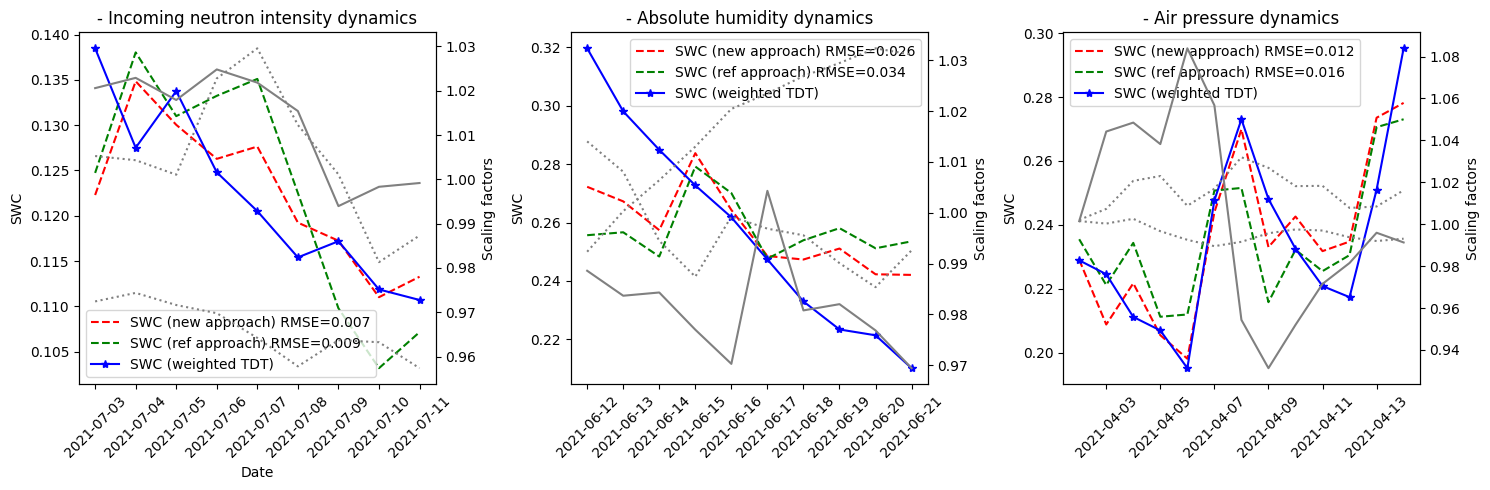

Save file as ./plots/Alento2_scaling_plotted.png

Block completed at time:                       12:04:52 on 2024-10-04


In [12]:

# Function to calculate RMSE
def calculate_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


filtered_df = merged_df.copy()
#print(merged_df.index)
#print(merged_df.columns)

# Convert 'Date' column to datetime format if not already
#filtered_df['Date'] = pd.to_datetime(filtered_df['Date'])

# Set 'Date' column as the index
#filtered_df.set_index('Date', inplace=True)


#print(filtered_df.index)
# Ensure the index is in datetime format
#filtered_df.index = pd.to_datetime(filtered_df.index)#

#print(filtered_df.index)

beta_ref=-0.0076
omega_ref=-0.0054
psi_ref=0.8
bd = 1.126
lw=0.055

filtered_df["SWC_Weighted"] = filtered_df["SWC_15cm"].copy()
depths = [0.05, 0.15]  # depths in cm
depths = [0.15, 0.30]  # depths in cm
radial_distance = 0  # assuming no radial distribution

print(len(filtered_df))
##Calculate weighting:
for ii in range(len(filtered_df)):
    #print(ii)
    swc_values = [filtered_df.loc[ii,"SWC_5cm"]+lw, filtered_df.loc[ii,"SWC_15cm"]+lw]
    # Calculate weighted SWC
    weighted_swcs = []
    for d, swc in zip(depths, swc_values):
        weight = CRNS_lib.Wd(d, radial_distance, bd, swc)
        weighted_swcs.append(swc * weight)

    # Calculate average weighted SWC
    average_weighted_swc = sum(weighted_swcs) / len(weighted_swcs)
    #print(f"Average Weighted SWC: {average_weighted_swc}")
    filtered_df.loc[ii,"SWC_Weighted"] = average_weighted_swc-lw





p_ref=np.nanmean(filtered_df['Pressure'])
i_ref=np.nanmean(filtered_df['Incoming'])
h_ref=np.nanmean(filtered_df['Abs_h'])


beta = dfi.loc[alento_site_start, 'beta']
omega = dfi.loc[alento_site_start, 'omega']
psi = dfi.loc[alento_site_start, 'psi']


the_indices = inc_indices.copy()

print("the_indices")
print(the_indices)
print("filtered_df.loc[the_indices[0],['SWC_Weighted']].values")
print(filtered_df.loc[the_indices[0],['SWC_Weighted']].values)

SWC_calib = np.mean(filtered_df.loc[inc_indices,['SWC_Weighted']].values)

print("CALIB SWC:")
print(SWC_calib)
cor_p_new = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta)
cor_h_new = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega)
cor_i_new = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi)

filtered_df["MOD_new"] = filtered_df['MOD'] / cor_p_new / cor_i_new / cor_h_new
Npih_calibrated = np.mean(filtered_df.loc[inc_indices,"MOD_new"])
N0_new = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_new = ((0.0808/((filtered_df.loc[inc_indices,"MOD_new"]/N0_new)-0.372)-0.115)*bd)-lw



cor_p = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta_ref)
cor_h = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega_ref)
cor_i = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi_ref)

filtered_df["MOD_standard"] = filtered_df['MOD'] / cor_p / cor_i / cor_h
Npih_calibrated = np.mean(filtered_df.loc[inc_indices,"MOD_standard"])
N0_standard = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_standard = ((0.0808/((filtered_df.loc[inc_indices,"MOD_standard"]/N0_standard)-0.372)-0.115)*bd)-lw

print(np.mean(SWC_new))
print(np.mean(SWC_standard))

print(the_indices)
print(filtered_df.loc[the_indices,'Date'])
print(" ")
print(" ")

# Create a figure with three columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax1 = axes[0]
# Assuming 'filtered_df' is your DataFrame and 'the_indices' are the indices of interest
# Compute RMSE values
rmse_new = calculate_rmse(filtered_df.loc[the_indices, 'SWC_Weighted'], SWC_new)
rmse_standard = calculate_rmse(filtered_df.loc[the_indices, 'SWC_Weighted'], SWC_standard)
label_new = f'SWC (new approach) RMSE={rmse_new:.3f}'
label_standard = f'SWC (ref approach) RMSE={rmse_standard:.3f}'

improvement_percent = ((rmse_standard - rmse_new) / rmse_standard) * 100
print("Improvement incoming neutrons:", improvement_percent, "%")
print(" ")


# Plot the four SWC lines
ax1.plot(filtered_df.loc[the_indices,'Date'], SWC_new,       label=label_new, color='red', linestyle='--')
ax1.plot(filtered_df.loc[the_indices,'Date'], SWC_standard,  label=label_standard, color='green', linestyle='--')
#ax1.plot(filtered_df.loc[inc_indices,'Date'], filtered_df.loc[inc_indices, 'SWC_5cm'],  label='SWC ( 5cm TDT)', color='blue', marker='*',linestyle='-')
ax1.plot(filtered_df.loc[the_indices,'Date'], filtered_df.loc[the_indices, 'SWC_Weighted'],  label='SWC (weighted TDT)', color='blue', marker='*',linestyle='-')
#ax1.plot(filtered_df.loc[inc_indices,'Date'], filtered_df.loc[inc_indices, 'SWC_5cm'], label='SWC (observed 5cm)', color='blue', marker='',linestyle='-')
#ax1.plot(filtered_df.loc[inc_indices,'Date'], filtered_df.loc[inc_indices, 'SWC_15cm'], label='SWC (15cm TDT)', color='purple', linestyle=':')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.tick_params(axis='x', rotation=45)
# Add a legend
ax1.legend()
# Add labels
ax1.set_xlabel('Date')
ax1.set_ylabel('SWC')
# Create a second y-axis for 'Incoming'
ax2 = ax1.twinx()

ax2.plot(filtered_df.loc[the_indices,'Date'], cor_p[the_indices], color='grey', linestyle=':')
ax2.plot(filtered_df.loc[the_indices,'Date'], cor_i[the_indices], color='grey', linestyle='-')
ax2.plot(filtered_df.loc[the_indices,'Date'], cor_h[the_indices], color='grey', linestyle=':')
ax2.set_ylabel('Scaling factors')
ax2.set_title('- Incoming neutron intensity dynamics')
# Add a legend for the secondary y-axis


the_indices = abs_indices.copy()

SWC_calib = np.mean(filtered_df.loc[the_indices,['SWC_Weighted']].values)

cor_p_new = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta)
cor_h_new = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega)
cor_i_new = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi)

filtered_df["MOD_new"] = filtered_df['MOD'] / cor_p_new / cor_i_new / cor_h_new
Npih_calibrated = np.mean(filtered_df.loc[the_indices,"MOD_new"])
N0_new = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_new = ((0.0808/((filtered_df.loc[the_indices,"MOD_new"]/N0_new)-0.372)-0.115)*bd)-lw



cor_p = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta_ref)
cor_h = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega_ref)
cor_i = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi_ref)

filtered_df["MOD_standard"] = filtered_df['MOD'] / cor_p / cor_i / cor_h
Npih_calibrated = np.mean(filtered_df.loc[the_indices,"MOD_standard"])
N0_standard = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_standard = ((0.0808/((filtered_df.loc[the_indices,"MOD_standard"]/N0_standard)-0.372)-0.115)*bd)-lw



ax1 = axes[1]
# Assuming 'filtered_df' is your DataFrame and 'the_indices' are the indices of interest
# Compute RMSE values
rmse_new = calculate_rmse(filtered_df.loc[the_indices, 'SWC_Weighted'], SWC_new)
rmse_standard = calculate_rmse(filtered_df.loc[the_indices, 'SWC_Weighted'], SWC_standard)
label_new = f'SWC (new approach) RMSE={rmse_new:.3f}'
label_standard = f'SWC (ref approach) RMSE={rmse_standard:.3f}'

improvement_percent = ((rmse_standard - rmse_new) / rmse_standard) * 100
print("Improvement absolute air humidity:", improvement_percent, "%")
print(" ")

# Plot the four SWC lines
ax1.plot(filtered_df.loc[the_indices,'Date'], SWC_new,       label=label_new, color='red', linestyle='--')
ax1.plot(filtered_df.loc[the_indices,'Date'], SWC_standard,  label=label_standard, color='green', linestyle='--')
ax1.plot(filtered_df.loc[the_indices,'Date'], filtered_df.loc[the_indices, 'SWC_Weighted'], label='SWC (weighted TDT)', color='blue', marker='*',linestyle='-')
#ax1.plot(filtered_df.loc[the_indices,'Date'], filtered_df.loc[the_indices, 'SWC_15cm'], label='SWC (15cm TDT)', color='purple', linestyle=':')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.tick_params(axis='x', rotation=45)
ax1.legend()
# Add labels
ax1.set_ylabel('SWC')
# Create a second y-axis for 'Incoming'
ax2 = ax1.twinx()
ax2.plot(filtered_df.loc[the_indices,'Date'], cor_p[the_indices], color='grey', linestyle=':')
ax2.plot(filtered_df.loc[the_indices,'Date'], cor_i[the_indices], color='grey', linestyle=':')
ax2.plot(filtered_df.loc[the_indices,'Date'], cor_h[the_indices], color='grey', linestyle='-')
ax2.set_ylabel('Scaling factors')
ax2.set_title('- Absolute humidity dynamics')
# Add a legend for the secondary y-axis




the_indices = pres_indices.copy()

SWC_calib = np.mean(filtered_df.loc[the_indices,['SWC_Weighted']].values)
cor_p_new = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta)
cor_h_new = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega)
cor_i_new = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi)

filtered_df["MOD_new"] = filtered_df['MOD'] / cor_p_new / cor_i_new / cor_h_new
Npih_calibrated = np.mean(filtered_df.loc[the_indices,"MOD_new"])
N0_new = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_new = ((0.0808/((filtered_df.loc[the_indices,"MOD_new"]/N0_new)-0.372)-0.115)*bd)-lw


cor_p = CRNS_opt.corr_exp_pressure(filtered_df['Pressure'], p_ref, beta_ref)
cor_h = CRNS_opt.corr_lin_humidity(filtered_df['Abs_h'], h_ref, omega_ref)
cor_i = CRNS_opt.corr_lin_incoming_correction(filtered_df['Incoming'],i_ref, psi_ref)

filtered_df["MOD_standard"] = filtered_df['MOD'] / cor_p / cor_i / cor_h
Npih_calibrated = np.mean(filtered_df.loc[the_indices,"MOD_standard"])
N0_standard = Npih_calibrated / (0.0808/((SWC_calib+lw) / bd + 0.115) + 0.372)
SWC_standard = ((0.0808/((filtered_df.loc[the_indices,"MOD_standard"]/N0_standard)-0.372)-0.115)*bd)-lw



ax1 = axes[2]
# Assuming 'filtered_df' is your DataFrame and 'the_indices' are the indices of interest
# Compute RMSE values
rmse_new = calculate_rmse(filtered_df.loc[the_indices, 'SWC_Weighted'], SWC_new)
rmse_standard = calculate_rmse(filtered_df.loc[the_indices, 'SWC_Weighted'], SWC_standard)
label_new = f'SWC (new approach) RMSE={rmse_new:.3f}'
label_standard = f'SWC (ref approach) RMSE={rmse_standard:.3f}'

improvement_percent = ((rmse_standard - rmse_new) / rmse_standard) * 100
print("Improvement atmospheric pressure:", improvement_percent, "%")
print(" ")

# Plot the four SWC lines
ax1.plot(filtered_df.loc[the_indices,'Date'], SWC_new,       label=label_new, color='red', linestyle='--')
ax1.plot(filtered_df.loc[the_indices,'Date'], SWC_standard,  label=label_standard, color='green', linestyle='--')
#ax1.plot(filtered_df.loc[the_indices,'Date'], filtered_df.loc[the_indices, 'SWC_5cm'], label='SWC (5cm TDT)', color='purple', linestyle='-.')
ax1.plot(filtered_df.loc[the_indices,'Date'], filtered_df.loc[the_indices, 'SWC_Weighted'], label='SWC (weighted TDT)', color='blue', marker='*',linestyle='-')
#ax1.plot(filtered_df.loc[the_indices,'Date'], filtered_df.loc[the_indices, 'SWC_15cm'], label='SWC (15cm TDT)', color='purple', linestyle=':')
ax1.legend()
# Add labels
ax1.set_ylabel('SWC')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.tick_params(axis='x', rotation=45)

# Create a second y-axis for 'Incoming'
ax2 = ax1.twinx()
ax2.plot(filtered_df.loc[the_indices,'Date'], cor_p[the_indices], color='grey', linestyle='-')
ax2.plot(filtered_df.loc[the_indices,'Date'], cor_i[the_indices], color='grey', linestyle=':')
ax2.plot(filtered_df.loc[the_indices,'Date'], cor_h[the_indices], color='grey', linestyle=':')
ax2.set_ylabel('Scaling factors')
ax2.set_title('- Air pressure dynamics')
# Add a legend for the secondary y-axis
# Adjust layout to prevent overlap
fig.tight_layout()

# Show plot
plt.show()


pngname="./plots/Alento2_scaling_plotted.png"
print("Save file as "+pngname)
fig.savefig(pngname, bbox_inches='tight')

print('\nBlock completed at time:                       '+ time.strftime("%H:%M:%S on %Y-%m-%d")) 
